# Scalar Newton's Method

Use first-order Taylor expansion to solve for a next iterate:

$u \leftarrow u - \frac{A(u)}{A'(u)}$


In [58]:
# Get some code for generating test problems from PyAMG
# PyAMG: https://github.com/pyamg/pyamg
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/diffusion.py
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/stencil.py
import stencil
import diffusion
import scipy.sparse as sp
import scipy.sparse.linalg as la
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def F(u):
    return u*u*u - 1
#     return u*u*u - 2*u + 2

def derivF(u):
    return 3.0*u*u
#     return 3.0*u*u - 2

In [60]:
def Newton(func, deriv_func, u):
    return float(u - func(u) / deriv_func(u))

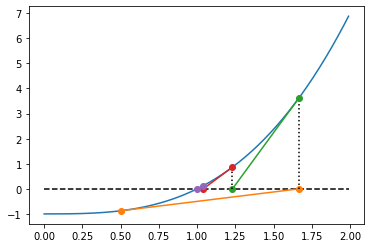

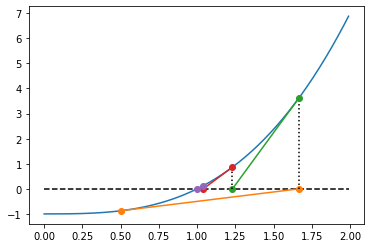

In [61]:
u = 0.5
x = np.arange(0,2,0.01)
y = F(x)
yprime = derivF(x) - 2
plt.plot(x,y)
plt.plot(x,np.zeros(len(x)),'--k')
for i in range(4):
    u_new = Newton(F,derivF,u)
    plt.plot([u,u_new],[F(u),0],'-o')
    plt.plot([u_new,u_new],[0,F(u_new)],':k')
    u = u_new
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1)

# Newton's Method for Systems:

When applied to systems, need to invert a Jacobian matrix:

$\mathbf{u} \leftarrow \mathbf{u} - (J(\mathbf{u}))^{-1}A(\mathbf{u})$

$   J(\mathbf{u})
   = 
   \begin{bmatrix}
   \frac{\partial A_1(\mathbf{u})}{\partial u_1} & \frac{\partial A_1(\mathbf{u})}{\partial u_2} & \dots & \frac{\partial A_1(\mathbf{u})}{\partial u_N} \\
   \frac{\partial A_2(\mathbf{u})}{\partial u_1} & \frac{\partial A_2(\mathbf{u})}{\partial u_2} & \dots & \frac{\partial A_2(\mathbf{u})}{\partial u_N} \\
   \vdots \\
   \frac{\partial A_N(\mathbf{u})}{\partial u_1} & \frac{\partial A_N(\mathbf{u})}{\partial u_2} & \dots & \frac{\partial A_N(\mathbf{u})}{\partial u_N}
   \end{bmatrix} $


In [74]:
# Non-linear diffusion-reaction problem
def A(u,f,gamma):
    N = len(u)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    sten = diffusion.diffusion_stencil_2d(epsilon=1.0, theta=0.0, type='FD')
    diff = (1.0/(h*h))*stencil.stencil_grid(sten, (n,n), format='csr')
    return diff*u + gamma*np.multiply(u,np.exp(u)) - f

# Jacobian of the non-linear diffusion-reaction problem
def Jac(u,gamma):
    N = len(u)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    sten = [[0,-1.0/(h*h),0],[-1.0/(h*h),4.0/(h*h),-1.0/(h*h)],[0,-1.0/(h*h),0]]
    M = stencil.stencil_grid(sten, (n,n), format='csr')
    D = sp.diags(gamma*(1.0 + np.multiply(u,np.exp(u))))
    return M + D

def RHS(N,gamma):
    f = np.zeros(N)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    for i in range(n):
        for j in range(n):
            x = (i+1)*h
            y = (j+1)*h
            f[i + j*n] = 2*((x - x*x) + (y-y*y)) + gamma*(x - x*x)*(y - y*y)*np.exp((x - x*x)*(y - y*y))
    return f

def Soln(N):
    f = np.zeros(N)
    n = int(np.sqrt(N))
    h = 1.0/(n+1)
    for i in range(n):
        for j in range(n):
            x = (i+1)*h
            y = (j+1)*h
            f[i + j*n] = (x - x*x)*(y-y*y)
    return f

In [75]:
def SystemsNewton(operator, jacobian, u, f, gamma):
    Au = operator(u, f, gamma)
    return u - la.spsolve(jacobian, Au)

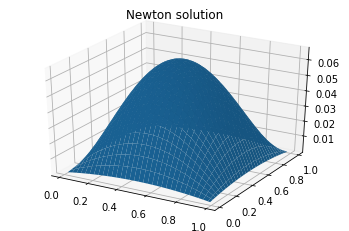

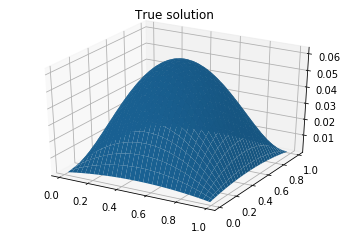

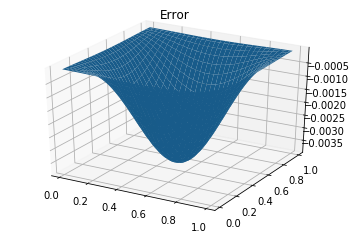

In [76]:
gamma = 1000
n = 64
N = n*n
X, Y = np.meshgrid(np.arange(1.0/(n+1),1.0,1.0/(n+1)),np.arange(1.0/(n+1),1.0,1.0/(n+1)))
u = np.zeros(N)
f = RHS(N,gamma)
for i in range(1):
    J = Jac(u,gamma)
    u_new = SystemsNewton(A, J, u, f, gamma)
    u = u_new
    
# Plot Newton solution
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Newton solution')
ax.plot_surface(X, Y, np.reshape(u,(n,n)))

# Plot true solution
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('True solution')
u_final = Soln(N)
ax.plot_surface(X, Y, np.reshape(u_final,(n,n)))

# Plot error
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Error')
u_final = Soln(N)
ax.plot_surface(X, Y, np.reshape(u_final - u,(n,n)))
